<a href="https://colab.research.google.com/github/emm-gl/WA2501_Machine_Learning_AI/blob/main/M%26DL2501-Math%26DeepLearning/Bloque04/DL_Multivar_Multistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Joining data:
**Time series with categoric data**

Link: [Kaggle](https://www.kaggle.com/datasets/utathya/future-volume-prediction?resource=download-directory&select=train_OwBvO8W)

Currently demand is estimated by sales executives, who generally have a “feel” for the market and predict the net effect of forces of supply, demand and other external factors based on past experience.

The more experienced a sales exec is in a particular market, the better a job he does at estimating.

Joshua, the new Head of S&OP for Stallion & Co. just took an analytics course and realized he can do the forecasts in a much more effective way.

**He approaches you, the best data scientist at Stallion, to transform the exercise of demand forecasting.**

Targets:
1. Create a dataset: joining the different tables.

# Pronostico de demanda

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, Model

import matplotlib.pyplot as plt

## Cargar dataset

In [8]:
root_path = "/content/train_OwBvO8W/"

In [26]:
vol = pd.read_csv(root_path + "historical_volume.csv")          #(hectoliters) Holds sales data at Agency-SKU-month level from Jan 2013 to Dec 2017
psp = pd.read_csv(root_path + "price_sales_promotion.csv")
wth = pd.read_csv(root_path + "weather.csv")
evt = pd.read_csv(root_path + "event_calendar.csv")
ind_soda = pd.read_csv(root_path + "industry_soda_sales.csv")   #(hectoliters) Holds industry level soda sales
ind_vol = pd.read_csv(root_path+ "industry_volume.csv")         # (hectoliters) Holds industry actual beer volume
demo = pd.read_csv(root_path +"demographics.csv")               # Holds demographic details (Yearly income in $)

In [27]:
vol.head()

,Agency,SKU,YearMonth,Volume
0,Agency_22,SKU_01,201301,52.2720
1,Agency_22,SKU_02,201301,110.7000
2,Agency_58,SKU_23,201301,0.0000
3,Agency_48,SKU_07,201301,28.3200
4,Agency_22,SKU_05,201301,238.5387


In [11]:
psp.head()

,Agency,SKU,YearMonth,Price,Sales,Promotions
0,Agency_01,SKU_01,201301,1141.500000,1033.432731,108.067269
1,Agency_01,SKU_01,201302,1141.500000,1065.417195,76.082805
2,Agency_01,SKU_01,201303,1179.345820,1101.133633,78.212187
3,Agency_01,SKU_01,201304,1226.687500,1138.283357,88.404143
4,Agency_01,SKU_01,201305,1230.331104,1148.969634,81.361470


In [12]:
wth.head()

,YearMonth,Agency,Avg_Max_Temp
0,201301,Agency_01,17.072
1,201302,Agency_01,19.984
2,201303,Agency_01,24.600
3,201304,Agency_01,27.532
4,201305,Agency_01,29.396


In [15]:
evt.head()

,YearMonth,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,201301,0,0,1,0,0,0,0,0,0,0,0,0
1,201302,0,0,0,0,0,0,0,0,0,0,0,0
2,201303,1,1,0,0,0,0,0,0,0,0,0,1
3,201304,0,0,0,0,0,0,0,0,0,0,0,0
4,201305,0,0,0,0,1,0,0,0,0,0,0,0


In [14]:
ind_soda.head()

,YearMonth,Soda_Volume
0,201301,718394219
1,201302,753938444
2,201303,892192092
3,201304,838099501
4,201305,864420003


In [13]:
demo.head()

,Agency,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,Agency_05,3044268,182944
1,Agency_02,3137874,240809
2,Agency_55,2025793,238553
3,Agency_53,1729177,111048
4,Agency_50,2057678,144594


In [16]:
def ensure_month(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["YearMonth"], format="%Y%m")
    df.drop(["YearMonth"], inplace=True, axis=1)
    return df

In [29]:
vol = ensure_month(vol)
psp = ensure_month(psp)
wth = ensure_month(wth)
evt = ensure_month(evt)
ind_soda = ensure_month(ind_soda)
ind_vol = ensure_month(ind_vol)

In [30]:
vol.head()

,Agency,SKU,Volume,date
0,Agency_22,SKU_01,52.2720,2013-01-01
1,Agency_22,SKU_02,110.7000,2013-01-01
2,Agency_58,SKU_23,0.0000,2013-01-01
3,Agency_48,SKU_07,28.3200,2013-01-01
4,Agency_22,SKU_05,238.5387,2013-01-01


In [31]:
def rename_keys(df):
    df = df.copy()
    ren = {}
    for c in df.columns:
        if c.lower() == "agency": ren[c] = "agency"
        if c.lower() == "sku": ren[c] = "sku"
    return df.rename(columns=ren)

vol, psp, wth, evt, ind_soda, ind_vol, demo = map(rename_keys, [vol, psp, wth, evt, ind_soda, ind_vol, demo])

In [32]:
vol.head()

,agency,sku,Volume,date
0,Agency_22,SKU_01,52.2720,2013-01-01
1,Agency_22,SKU_02,110.7000,2013-01-01
2,Agency_58,SKU_23,0.0000,2013-01-01
3,Agency_48,SKU_07,28.3200,2013-01-01
4,Agency_22,SKU_05,238.5387,2013-01-01


In [33]:
df = vol.merge(psp, on=["agency","sku","date"], how="left")
df = df.merge(wth, on=["agency","date"], how="left")
df = df.merge(evt, on=["date"], how="left")
df = df.merge(ind_soda, on=["date"], how="left")
df = df.merge(ind_vol, on=["date"], how="left")
df = df.merge(demo, on=["agency"], how="left")

In [34]:
df = df.sort_values(["agency","sku","date"]).reset_index(drop=True)

In [35]:
print(df.columns)

Index(['agency', 'sku', 'Volume', 'date', 'Price', 'Sales', 'Promotions',
       'Avg_Max_Temp', 'Easter Day', 'Good Friday', 'New Year', 'Christmas',
       'Labor Day', 'Independence Day', 'Revolution Day Memorial',
       'Regional Games ', 'FIFA U-17 World Cup', 'Football Gold Cup',
       'Beer Capital', 'Music Fest', 'Soda_Volume', 'Industry_Volume',
       'Avg_Population_2017', 'Avg_Yearly_Household_Income_2017'],
      dtype='object')


In [24]:
df.head()

,agency,sku,Volume,date,Price,Sales,Promotions,Avg_Max_Temp,Easter Day,Good Friday,...,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Soda_Volume,Industry_Volume,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,Agency_01,SKU_01,80.676,2013-01-01,1141.500000,1033.432731,108.067269,17.072,0,0,...,0,0,0,0,0,0,718394219,492612703,153733,120207
1,Agency_01,SKU_01,98.064,2013-02-01,1141.500000,1065.417195,76.082805,19.984,0,0,...,0,0,0,0,0,0,753938444,431937346,153733,120207
2,Agency_01,SKU_01,133.704,2013-03-01,1179.345820,1101.133633,78.212187,24.600,1,1,...,0,0,0,0,0,1,892192092,509281531,153733,120207
3,Agency_01,SKU_01,147.312,2013-04-01,1226.687500,1138.283357,88.404143,27.532,0,0,...,0,0,0,0,0,0,838099501,532390389,153733,120207
4,Agency_01,SKU_01,175.608,2013-05-01,1230.331104,1148.969634,81.361470,29.396,0,0,...,0,0,0,0,0,0,864420003,551755254,153733,120207


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            21000 non-null  object        
 1   sku                               21000 non-null  object        
 2   Volume                            21000 non-null  float64       
 3   date                              21000 non-null  datetime64[ns]
 4   Price                             21000 non-null  float64       
 5   Sales                             21000 non-null  float64       
 6   Promotions                        21000 non-null  float64       
 7   Avg_Max_Temp                      21000 non-null  float64       
 8   Easter Day                        21000 non-null  int64         
 9   Good Friday                       21000 non-null  int64         
 10  New Year                          21000 non-nu

# Preprocesado e ingeniería de variables

In [37]:
#####################################################################################################
TARGET_COL = "Volume"

# basic calendar features
df["month_num"] = df["date"].dt.month
df["year"] = df["date"].dt.year

# lags per series
g = df.groupby(["agency","sku"])
for l in [1,3,6,12]:
    df[f"{TARGET_COL}_lag_{l}"] = g[TARGET_COL].shift(l)

# rolling means
df[f"{TARGET_COL}_roll_3"] = g[TARGET_COL].shift(1).rolling(3).mean()
df[f"{TARGET_COL}_roll_6"] = g[TARGET_COL].shift(1).rolling(6).mean()

# drop early rows with NaNs from lags/rolls
df = df.dropna().reset_index(drop=True)

# log transform target
df["y"] = np.log1p(df[TARGET_COL].values)

In [38]:
df

,agency,sku,Volume,date,Price,Sales,Promotions,Avg_Max_Temp,Easter Day,Good Friday,...,Avg_Yearly_Household_Income_2017,month_num,year,Volume_lag_1,Volume_lag_3,Volume_lag_6,Volume_lag_12,Volume_roll_3,Volume_roll_6,y
0,Agency_01,SKU_01,100.548,2014-01-01,1235.187500,995.006244,240.181256,19.092308,0,0,...,120207,1,2014,104.544,149.364,149.796,80.676,116.424,134.658,4.620532
1,Agency_01,SKU_01,123.552,2014-02-01,1235.187500,1111.858392,123.329108,23.319231,0,0,...,120207,2,2014,100.548,95.364,161.136,98.064,100.152,126.450,4.824723
2,Agency_01,SKU_01,125.172,2014-03-01,1235.187500,1108.242181,126.945319,23.150000,0,0,...,120207,3,2014,123.552,104.544,147.744,133.704,109.548,120.186,4.837646
3,Agency_01,SKU_01,70.524,2014-04-01,1235.187500,1109.019047,126.168453,26.569231,1,1,...,120207,4,2014,125.172,100.548,149.364,147.312,116.424,116.424,4.270033
4,Agency_01,SKU_01,21.924,2014-05-01,1264.272500,1257.190000,7.082500,29.430769,0,0,...,120207,5,2014,70.524,123.552,95.364,175.608,106.416,103.284,3.132184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,Agency_60,SKU_23,1.980,2017-08-01,4254.975000,4254.975000,0.000000,28.417411,0,0,...,211936,8,2017,2.160,0.000,2.520,2.340,1.560,1.695,1.091923
16796,Agency_60,SKU_23,1.260,2017-09-01,4256.796429,4256.796429,0.000000,27.591111,0,0,...,211936,9,2017,1.980,2.520,1.710,3.600,2.220,1.605,0.815365
16797,Agency_60,SKU_23,0.990,2017-10-01,4262.625000,4262.625000,0.000000,27.558824,0,0,...,211936,10,2017,1.260,2.160,1.260,2.070,1.800,1.530,0.688135
16798,Agency_60,SKU_23,0.090,2017-11-01,4262.625000,4262.625000,0.000000,27.674091,0,0,...,211936,11,2017,0.990,1.980,0.000,0.360,1.410,1.485,0.086178


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            16800 non-null  object        
 1   sku                               16800 non-null  object        
 2   Volume                            16800 non-null  float64       
 3   date                              16800 non-null  datetime64[ns]
 4   Price                             16800 non-null  float64       
 5   Sales                             16800 non-null  float64       
 6   Promotions                        16800 non-null  float64       
 7   Avg_Max_Temp                      16800 non-null  float64       
 8   Easter Day                        16800 non-null  int64         
 9   Good Friday                       16800 non-null  int64         
 10  New Year                          16800 non-nu

In [40]:
# Variables numéricas
exclude = {"date","agency","sku",TARGET_COL,"y"}
num_cols = [c for c in df.columns if c not in exclude and df[c].dtype != "object"]

In [41]:
num_cols

['Price',
 'Sales',
 'Promotions',
 'Avg_Max_Temp',
 'Easter Day',
 'Good Friday',
 'New Year',
 'Christmas',
 'Labor Day',
 'Independence Day',
 'Revolution Day Memorial',
 'Regional Games ',
 'FIFA U-17 World Cup',
 'Football Gold Cup',
 'Beer Capital',
 'Music Fest',
 'Soda_Volume',
 'Industry_Volume',
 'Avg_Population_2017',
 'Avg_Yearly_Household_Income_2017',
 'month_num',
 'year',
 'Volume_lag_1',
 'Volume_lag_3',
 'Volume_lag_6',
 'Volume_lag_12',
 'Volume_roll_3',
 'Volume_roll_6']

In [42]:
len(num_cols)

28

In [43]:
# ids
agency_ids = {a:i for i,a in enumerate(df["agency"].unique())}
sku_ids = {s:i for i,s in enumerate(df["sku"].unique())}
df["agency_id"] = df["agency"].map(agency_ids)
df["sku_id"] = df["sku"].map(sku_ids)

In [ ]:
# scale numerics
#scaler = StandardScaler()
#df[num_cols] = scaler.fit_transform(df[num_cols].values)

In [ ]:
# IMPORTANT scaling without leakage:
val_start = pd.Timestamp("2017-07-01")        # Validation data: From JUL-2017 to DEC-2017
train_rows = df["date"] < val_start           #Trainning data: From JUN-2013 to JUN-2017

scaler = StandardScaler()
df.loc[train_rows, num_cols] = scaler.fit_transform(df.loc[train_rows, num_cols].values)    #--> Trainning Data
df.loc[~train_rows, num_cols] = scaler.transform(df.loc[~train_rows, num_cols].values)      #--> VALIDATION DATA (~train_rows means 'not train_rows') are selected ->

In [45]:
df

,agency,sku,Volume,date,Price,Sales,Promotions,Avg_Max_Temp,Easter Day,Good Friday,...,year,Volume_lag_1,Volume_lag_3,Volume_lag_6,Volume_lag_12,Volume_roll_3,Volume_roll_6,y,agency_id,sku_id
0,Agency_01,SKU_01,100.548,2014-01-01,-0.345801,-0.492425,0.179449,-2.402788,-0.324443,-0.324443,...,-1.248075,-0.509786,-0.494511,-0.495681,-0.526052,-0.511503,-0.507231,4.620532,0,0
1,Agency_01,SKU_01,123.552,2014-02-01,-0.345801,-0.291608,-0.236224,-1.317223,-0.324443,-0.324443,...,-1.248075,-0.511255,-0.514575,-0.491478,-0.519507,-0.517584,-0.510319,4.824723,0,0
2,Agency_01,SKU_01,125.172,2014-03-01,-0.345801,-0.297823,-0.223360,-1.360685,-0.324443,-0.324443,...,-1.248075,-0.502801,-0.511164,-0.496442,-0.506092,-0.514073,-0.512676,4.837646,0,0
3,Agency_01,SKU_01,70.524,2014-04-01,-0.345801,-0.296487,-0.226124,-0.482552,3.082207,3.082207,...,-1.248075,-0.502206,-0.512649,-0.495841,-0.500969,-0.511503,-0.514091,4.270033,0,0
4,Agency_01,SKU_01,21.924,2014-05-01,-0.303161,-0.041847,-0.649743,0.252353,-0.324443,-0.324443,...,-1.248075,-0.522289,-0.504102,-0.515858,-0.490318,-0.515243,-0.519035,3.132184,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,Agency_60,SKU_23,1.980,2017-08-01,4.081384,5.110031,-0.674937,-0.007899,-0.324443,-0.324443,...,1.664101,-0.547412,-0.550009,-0.550274,-0.555539,-0.554427,-0.557254,1.091923,57,12
16796,Agency_60,SKU_23,1.260,2017-09-01,4.084054,5.113161,-0.674937,-0.220111,-0.324443,-0.324443,...,1.664101,-0.547478,-0.549073,-0.550574,-0.555065,-0.554180,-0.557288,0.815365,57,12
16797,Agency_60,SKU_23,0.990,2017-10-01,4.092599,5.123178,-0.674937,-0.228403,-0.324443,-0.324443,...,1.664101,-0.547743,-0.549207,-0.550741,-0.555641,-0.554337,-0.557316,0.688135,57,12
16798,Agency_60,SKU_23,0.090,2017-11-01,4.092599,5.123178,-0.674937,-0.198800,-0.324443,-0.324443,...,1.664101,-0.547842,-0.549274,-0.551208,-0.556284,-0.554483,-0.557333,0.086178,57,12


In [46]:
#############################################################################3

LOOKBACK = 24
HORIZON = 3

def make_windows(frame):
    X_seq, X_ag, X_sku, Y = [], [], [], []
    for (a, s), sub in frame.groupby(["agency_id","sku_id"], sort=False):
        sub = sub.sort_values("date")
        x_num = sub[num_cols].values
        y = sub["y"].values
        for t in range(LOOKBACK, len(sub) - HORIZON + 1):
            X_seq.append(x_num[t-LOOKBACK:t])
            X_ag.append(a)
            X_sku.append(s)
            Y.append(y[t:t+HORIZON])
    return np.array(X_seq), np.array(X_ag), np.array(X_sku), np.array(Y)

def make_windows_with_dates(frame):
    X_seq, X_ag, X_sku, Y, y_month = [], [], [], [], []
    for (a, s), sub in frame.groupby(["agency_id","sku_id"], sort=False):
        sub = sub.sort_values("date")
        x_num = sub[num_cols].values
        y = sub["y"].values
        months = sub["date"].values
        for t in range(LOOKBACK, len(sub) - HORIZON + 1):
            X_seq.append(x_num[t-LOOKBACK:t])
            X_ag.append(a)
            X_sku.append(s)
            Y.append(y[t:t+HORIZON])
            y_month.append(months[t])  # forecast starts here
    return (np.array(X_seq),
            np.array(X_ag),
            np.array(X_sku),
            np.array(Y).reshape(-1, HORIZON),
            pd.to_datetime(np.array(y_month)))

In [47]:
X_seq, X_ag, X_sku, Y, y_month = make_windows_with_dates(df)
print(X_seq.shape, X_ag.shape, X_sku.shape, Y.shape, y_month.shape)

(7700, 24, 28) (7700,) (7700,) (7700, 3) (7700,)


In [48]:
#Data split:

train_idx = y_month < val_start
val_idx = y_month >= val_start

Xtr = [X_seq[train_idx], X_ag[train_idx], X_sku[train_idx]]
Ytr = Y[train_idx]
Xva = [X_seq[val_idx], X_ag[val_idx], X_sku[val_idx]]
Yva = Y[val_idx]
mva = y_month[val_idx]

print("Train windows:", len(Ytr), "Val windows:", len(Yva))

Train windows: 6300 Val windows: 1400


# Modelo: LSTM + embeddings + Dense

In [49]:
n_agency = len(agency_ids)
n_sku = len(sku_ids)
n_feat = X_seq.shape[-1]

emb_dim = 16
lstm_units = 64

In [ ]:
#text
#tokenizen: ---> {"hello":1, "what":2, ...}
#embedding: ---> id ---> vector

#Example:  word2vec

In [50]:
#Working with the ids: reminder the id mapping of the skus and agencies



seq_in = layers.Input(shape=(LOOKBACK, n_feat), name="seq")
ag_in = layers.Input(shape=(), dtype="int32", name="agency_id")
sku_in = layers.Input(shape=(), dtype="int32", name="sku_id")

ag_emb = layers.Flatten()(layers.Embedding(n_agency, emb_dim)(ag_in))
sku_emb = layers.Flatten()(layers.Embedding(n_sku, emb_dim)(sku_in))

x = layers.LSTM(lstm_units)(seq_in)
x = layers.Concatenate()([x, ag_emb, sku_emb])
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(HORIZON)(x)

model = Model([seq_in, ag_in, sku_in], out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ agency_id           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sku_id (InputLayer) │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq (InputLayer)    │ (None, 24, 28)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 16)        │        928 │ agency_id[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 16)        │        400 │ sku_id[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     23,808 │ seq[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,939 (148.20 KB)

 Trainable params: 37,939 (148.20 KB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento

In [51]:
BATCH = 128

train_ds = tf.data.Dataset.from_tensor_slices(((Xtr[0], Xtr[1], Xtr[2]), Ytr))
train_ds = train_ds.shuffle(20000).batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(((Xva[0], Xva[1], Xva[2]), Yva))
val_ds = val_ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks, verbose=1)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 23.4326 - mae: 3.9881 - val_loss: 3.2005 - val_mae: 1.4385 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3704 - mae: 1.2268 - val_loss: 1.0255 - val_mae: 0.7227 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1580 - mae: 0.8390 - val_loss: 0.7987 - val_mae: 0.6026 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9147 - mae: 0.7458 - val_loss: 0.7002 - val_mae: 0.5656 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8898 - mae: 0.7267 - val_loss: 0.6684 - val_mae: 0.5572 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7827 - mae: 0.6790 - val_loss: 0.5619 - val_mae: 0.5144 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7564 - mae: 0.6681 - val_loss: 0.6134 - val_mae: 0.5724 - learning_rate: 0.0010
Epoch 8/50
50/5

#  Pronostico en validación

In [52]:
Yhat = model.predict(Xva, batch_size=2048)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


In [54]:
Xva[0].shape

(1400, 24, 28)

In [55]:
Xva[1].shape

(1400,)

In [56]:
Xva[2].shape

(1400,)

In [57]:
Yhat.shape

(1400, 3)

In [58]:
Yva.shape

(1400, 3)

In [59]:
# pick one series to plot (first available in validation)
one_ag = int(Xva[1][1000])
one_sku = int(Xva[2][1000])

In [60]:
one_ag

43

In [61]:
one_sku

2

In [62]:
mask = (Xva[1] == one_ag) & (Xva[2] == one_sku)
m_one = mva[mask]
y_true = Yva[mask]
y_pred = Yhat[mask]

In [63]:
# sort by month
order = np.argsort(m_one.values)

month = 2
m_one = m_one[order][month]
y_true = y_true[order][month]
y_pred = y_pred[order][month]

In [64]:
m_one

Timestamp('2017-09-01 00:00:00')

In [65]:
Xva[0][mask].shape # (monht, past, feature)

(4, 24, 28)

In [66]:
X_past = scaler.inverse_transform(Xva[0][mask][month])

In [67]:
k_volume_index = 22
past = X_past[:,k_volume_index]

In [68]:
# Plot in original volume
vol_true = np.expm1(y_true)
vol_pred = np.expm1(y_pred)

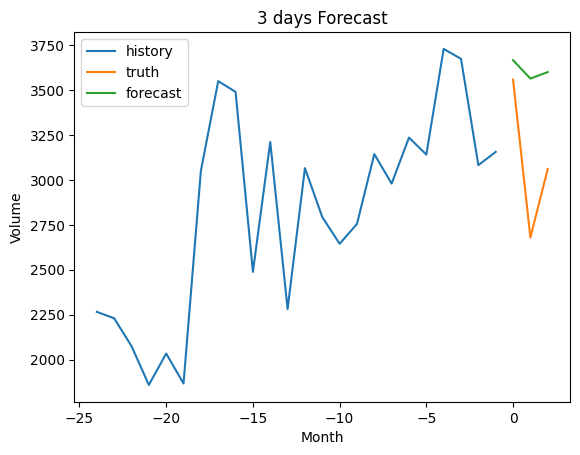

In [69]:
plt.figure()
plt.plot(range(-len(past), 0), past, label="history")
plt.plot(range(0, len(vol_true)), vol_true, label="truth")
plt.plot(range(0, len(vol_pred)), vol_pred, label="forecast")
plt.title(f"3 days Forecast")
plt.xlabel("Month")
plt.ylabel("Volume")
plt.legend()
plt.show()

In [70]:
# Quick numeric check
mae_vol = np.mean(np.abs(vol_true - vol_pred))
print("MAE (volume) for this one series on val months:", mae_vol)

MAE (volume) for this one series on val months: 510.62887851562374
